# Málaga Airbnb Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In this notebook, I'll follow the CRISP-DM process to analyze Málaga Airbnb homes data and answer the following questions:
- What is the perfect time of year to visit Málaga city ?
- Which neighborhood is more affordable and less crowded ?
- Which features is more involved in predicting price ?   


by separating the notebook into 3 parts and show you the details that drive me to the answers

## Part 1:
<h2>What is the perfect time of year to visit Málaga city ?</h2>

### 1.Gather

In [2]:
calendar_df=pd.read_csv("data/calendar.zip",compression='zip') #Loading calendar data

### 2.Assess

In [3]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2334175 entries, 0 to 2334174
Data columns (total 7 columns):
listing_id        int64
date              object
available         object
price             object
adjusted_price    object
minimum_nights    int64
maximum_nights    int64
dtypes: int64(3), object(4)
memory usage: 124.7+ MB


In [4]:
calendar_df.describe()

,listing_id,minimum_nights,maximum_nights
count,2.334175e+06,2.334175e+06,2.334175e+06
mean,2.637861e+07,4.369014e+00,8.335845e+02
std,1.122482e+07,2.753960e+01,4.675077e+02
min,9.603300e+04,1.000000e+00,1.000000e+00
25%,1.837136e+07,2.000000e+00,3.000000e+02
50%,2.708001e+07,2.000000e+00,1.125000e+03
75%,3.601766e+07,3.000000e+00,1.125000e+03
max,4.262131e+07,1.125000e+03,1.127000e+03


In [5]:
calendar_df.isna().sum()

listing_id        0
date              0
available         0
price             0
adjusted_price    0
minimum_nights    0
maximum_nights    0
dtype: int64

In [6]:
calendar_df.duplicated().sum()

0

### 3.Clean & Analyize

In [7]:
#remove '$' and ',' from price and cast it to float
calendar_df.price=calendar_df.price.apply(lambda x:x[1:].replace(',','')).astype(float)
pd.DataFrame(calendar_df['price'].sample(5))

,price
1853265,120.0
2310439,81.0
2112324,900.0
379274,40.0
136723,98.0


In [8]:
#change 'date' column type from 'str' to 'datetime'
calendar_df['date']=pd.to_datetime(calendar_df['date'])
pd.DataFrame(calendar_df['date'].sample(5))

,date
249741,2020-08-15
548812,2020-06-03
1556217,2020-10-11
220317,2020-05-21
331332,2020-06-28


### 4.Model and Visualize

In [9]:
# Create new columns to split date to year, month, and day
calendar_df['year'] = calendar_df['date'].dt.year
calendar_df['month'] = calendar_df['date'].dt.month
calendar_df['day'] = calendar_df['date'].dt.day

In [10]:
calendar_df.sample(3)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,year,month,day
935462,23815426,2020-03-27,t,89.0,$89.00,2,1125,2020,3,27
334782,13966708,2020-03-13,f,90.0,$90.00,3,30,2020,3,13
864793,22757790,2020-07-31,f,108.0,$108.00,1,1125,2020,7,31


In [11]:
#check values of available column
pd.DataFrame(calendar_df.available.value_counts())

,available
t,1317120
f,1017055


In [12]:
#convert available value from t to 1 and f to 0
calendar_df.available=calendar_df.available.map({'t':1,'f':0})
pd.DataFrame(calendar_df['available'].value_counts())

,available
1,1317120
0,1017055


In [13]:
month_availability=calendar_df.groupby(['month'])['available'].mean().sort_values(ascending=False)
pd.DataFrame(month_availability)

,available
month,
7,0.625312
8,0.619622
5,0.618306
6,0.608314
9,0.604154
10,0.599546
11,0.599364
4,0.541089
12,0.538036


In [14]:
#some stats about month_availability
pd.DataFrame(month_availability.describe())

,available
count,12.000000
mean,0.563760
std,0.062893
min,0.462463
25%,0.523675
50%,0.599455
75%,0.610812
max,0.625312


In [15]:
# I'll consider months with the average amount of available present over 0.61 to be active (above 75% of data)
active_months_val=month_availability[month_availability>0.61]
active_months=active_months_val.index.tolist()
active_months

[7, 8, 5]

In [16]:
# and I'll consider months with the average amount of available present under 0.52 to be inactive (below 25% of data)
inactive_months_val=month_availability[month_availability<0.523]

# Get names of active months
inactive_months=inactive_months_val.index.tolist()
inactive_months

[1, 2, 3]

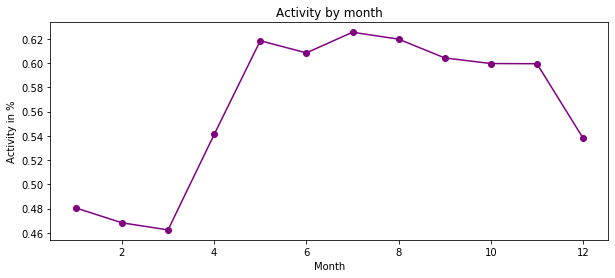

In [26]:
#Plot Availability by month
plt.figure(figsize=(10,4))
plt.plot(month_availability.sort_index(), 'o-',color='purple')
plt.xlabel('Month')
plt.ylabel('Activity in %')
plt.title('Activity by month')
plt.show()

- Based on the above graph:
    - May, July, and August are the most available time of the year to visit Malaga city.
    - January, February and March are the least.

But what about days let's try to explore it

#### I. Active Days

In [27]:
# Separate the active months in another dataframe
active_months_df=calendar_df[calendar_df['month'].isin(active_months)] 

# Count of availability for each day
active_months_available_days=active_months_df.groupby(['day'])['available'].mean().sort_values(ascending=False)
pd.DataFrame(active_months_available_days)

,available
day,
27,0.659004
26,0.658952
25,0.652906
24,0.646547
12,0.636800
28,0.635757
13,0.632317
31,0.632004
23,0.631691


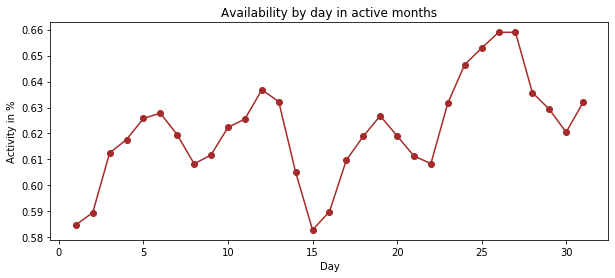

In [34]:
#Plot Availability by Day in active months
plt.figure(figsize=(10,4))
plt.plot(active_months_available_days.sort_index(), 'o-', color='brown')
plt.xlabel('Day')
plt.ylabel('Activity in %')
plt.title('Availability by day in active months')
plt.show()

#### II. Inactive Days

In [31]:
# Separate the inactive months in another dataframe
inactive_months_df=calendar_df[calendar_df['month'].isin(inactive_months)] 

# Count of availability for each day
inactive_months_available_days=inactive_months_df.groupby(['day'])['available'].mean().sort_values(ascending=False)
pd.DataFrame(inactive_months_available_days)

,available
day,
31,0.526349
30,0.517748
29,0.505395
24,0.499661
25,0.496846
23,0.495856
17,0.489653
26,0.489601
10,0.488350


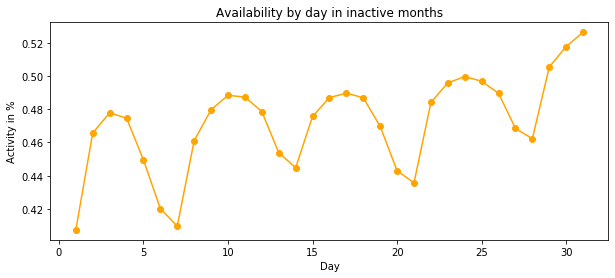

In [37]:
#Plot Availability by Day in inactive months
plt.figure(figsize=(10,4))
plt.plot(inactive_months_available_days.sort_index(), 'o-',color="Orange")
plt.xlabel('Day')
plt.ylabel('Activity in %')
plt.title('Availability by day in inactive months')
plt.show()

All the above exploring was about availability but what about price let's take it a look

In [38]:
# Average price per months
month_price=calendar_df.groupby(['month'])['price'].mean().sort_values(ascending=False)
pd.DataFrame(month_price)

,price
month,
2,407.867346
1,382.065429
12,164.219108
9,156.181324
10,150.027264
11,147.509950
8,146.121547
7,124.526354
6,110.661704


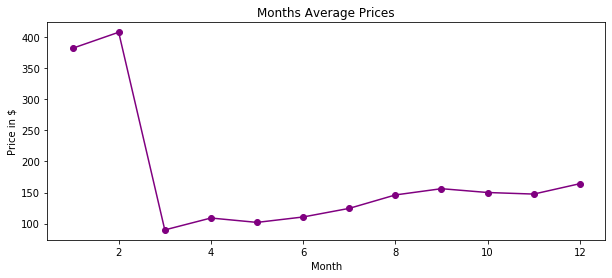

In [41]:
plt.figure(figsize=(10,4))
plt.xlabel('Month')
plt.ylabel('Price in $')
plt.title('Months Average Prices')
plt.plot(month_price.sort_index(), 'o-',color='purple');

In [42]:
# Get statistical information
pd.DataFrame(month_price.describe())

,price
count,12.000000
mean,174.163595
std,105.920524
min,89.849106
25%,110.243410
50%,146.815749
75%,158.190770
max,407.867346


In [43]:
# Consider months with avergae price over 158 to be expensive (above 75% of data)
high_price_months=month_price[month_price>158]

# Get names of high price months
expensive_months=high_price_months.index.tolist()
expensive_months

[2, 1, 12]

In [44]:
# Consider months with avergae price over 110 to be expensive (less 25% of data)
low_price_months=month_price[month_price<110]

# Get names of high price months
cheap_months=low_price_months.index.tolist()
cheap_months

[4, 5, 3]

- Based on the above analyzing:
    - Prices increase in Winter season, mostly in December, January and February
    - Prices decrease in Spring season in March, April and May
    
So we can apply some rules to get the best time to visit Malaga:

In [27]:
# Get active and expensive months
print("Active and expensive months :",list(set(expensive_months) & set(active_months)))
# Get inactive and expensive months
print("Inactive and expensive months :",list(set(expensive_months) & set(inactive_months)))
# Get active and cheap months
print("Active and cheap months :",list(set(cheap_months) & set(active_months)))
# Get inactive and cheap months
print("Inactive and cheap months :",list(set(cheap_months) & set(inactive_months)))

Active and expensive months : []
Inactive and expensive months : [1, 2]
Active and cheap months : [5]
Inactive and cheap months : [3]


#### In Conclusion
"March is the less crowded and most affordable time in year to visit Malaga"

## Part 2:
<h2>Which neighborhood is more affordable and less crowded?</h2>

### 1.Gather

In [45]:
#load listings data with just used columns
listings_df = pd.read_csv('data/listings.zip',compression='zip',usecols=['id','neighbourhood_cleansed','price'])
listings_df.sample(5)

,id,neighbourhood_cleansed,price
1712,19061175,Centro,$90.00
4413,34405589,Centro,$20.00
749,11947508,Carretera de Cadiz,$70.00
922,13870789,Centro,$65.00
4362,34056868,Ciudad Jardin,$120.00


### 2.Assess

In [46]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6395 entries, 0 to 6394
Data columns (total 3 columns):
id                        6395 non-null int64
neighbourhood_cleansed    6395 non-null object
price                     6395 non-null object
dtypes: int64(1), object(2)
memory usage: 150.0+ KB


In [47]:
listings_df.describe()

,id
count,6.395000e+03
mean,2.637861e+07
std,1.122570e+07
min,9.603300e+04
25%,1.837153e+07
50%,2.708001e+07
75%,3.601457e+07
max,4.262131e+07


### 3.Clean & Analyize

In [48]:
listings_df.isna().sum()

id                        0
neighbourhood_cleansed    0
price                     0
dtype: int64

In [49]:
listings_df.duplicated().sum()

0

In [50]:
#remove '$' and ',' from price and cast it to float
listings_df.price=listings_df.price.apply(lambda x:x[1:].replace(',','')).astype(float)
pd.DataFrame(listings_df['price'].sample(5))

,price
4364,60.0
4730,31.0
5487,200.0
4705,75.0
2439,39.0


as we see the data havn't null or dupicated rows

### 4.Model & Visualize

#### I.Price

In [51]:
# Average price for each neighbourhood group
neighbourhood_price=listings_df.groupby(['neighbourhood_cleansed'])['price'].mean()

# Sort values in descending order
neighbourhood_price=neighbourhood_price.sort_values(ascending=False)
pd.DataFrame(neighbourhood_price)

,price
neighbourhood_cleansed,
Churriana,119.829787
Centro,104.956950
Este,102.696124
Puerto de la Torre,99.289474
Carretera de Cadiz,87.034111
Teatinos-Universidad,86.444444
Palma-Palmilla,78.043478
Campanillas,77.500000
Cruz De Humilladero,73.524430


In [52]:
# get stats info
pd.DataFrame(neighbourhood_price.describe())

,price
count,11.000000
mean,85.170850
std,20.921637
min,48.449438
25%,75.512215
50%,86.444444
75%,100.992799
max,119.829787


In [53]:
# Consider neighbourhood with avergae price over 101 to be expensive (above 75% of data)
high_price_neighbourhood_val=neighbourhood_price[neighbourhood_price>101]

# Get names of high price neighbourhoods
expensive_neighbourhoods=high_price_neighbourhood_val.index.tolist()
expensive_neighbourhoods

['Churriana', 'Centro', 'Este']

In [54]:
# Consider neighbourhood with avergae price less tahn 75 to be expensive (under 25% of data)
low_price_neighbourhood_val=neighbourhood_price[neighbourhood_price<75.5]

# Get names of high price neighbourhoods
cheap_neighbourhoods=low_price_neighbourhood_val.index.tolist()
cheap_neighbourhoods

['Cruz De Humilladero', 'Ciudad Jardin', 'Bailen-Miraflores']

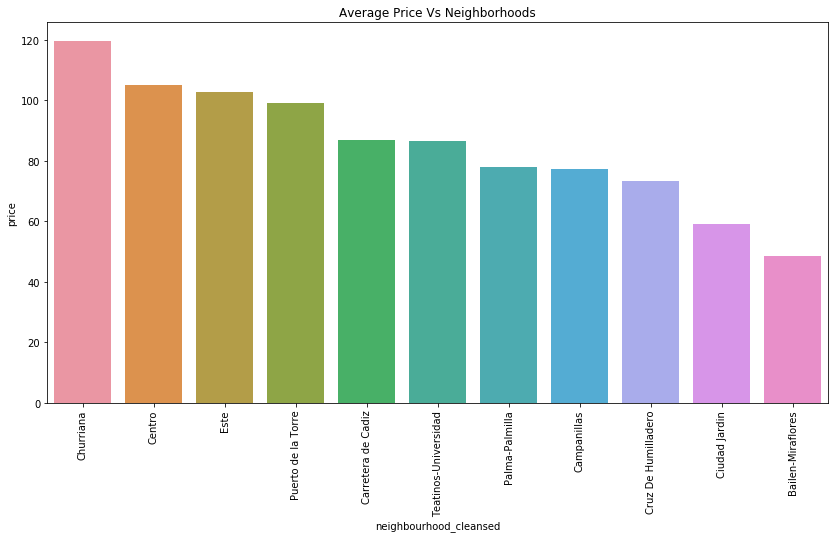

In [38]:
# Plot the average price per neighbourhoods
plt.figure(figsize=(14,7))
plt.xticks(rotation=90)
plt.xlabel('Neighborhoods')
plt.ylabel('Price')
plt.title('Average Price Vs Neighborhoods')
sns.barplot(neighbourhood_price.index,neighbourhood_price);

- Based on the above analysis,
    - Churriana, Centro and  Este are the most expensive.
    - Cruz De Humilladero, Ciudad Jardin and Bailen-Miraflores are the cheapest.

#### II. Popularity

In [55]:
# The average number of listings for each neighbourhood group
neighbourhoods_popularity=listings_df.groupby(['neighbourhood_cleansed'])['id'].mean()

# Sort values in descending order
neighbourhoods_popularity=neighbourhoods_popularity.sort_values(ascending=False)
pd.DataFrame(neighbourhoods_popularity)

,id
neighbourhood_cleansed,
Campanillas,3.118646e+07
Cruz De Humilladero,2.948411e+07
Ciudad Jardin,2.850531e+07
Palma-Palmilla,2.743593e+07
Churriana,2.736920e+07
Bailen-Miraflores,2.704404e+07
Carretera de Cadiz,2.689461e+07
Centro,2.639207e+07
Este,2.436559e+07


In [56]:
# get stats info
pd.DataFrame(neighbourhoods_popularity.describe())

,id
count,1.100000e+01
mean,2.686464e+07
std,2.434618e+06
min,2.311272e+07
25%,2.537883e+07
50%,2.704404e+07
75%,2.797062e+07
max,3.118646e+07


In [57]:
# Consider neighbourhood with The average number of listings over 2.797062e+07 to be popular (above 75% of data)
pop_neighbourhood_val=neighbourhoods_popularity[neighbourhoods_popularity>2.797062e+07]

# Get names of high price months
pop_neighbourhood=pop_neighbourhood_val.index.tolist()
pop_neighbourhood

['Campanillas', 'Cruz De Humilladero', 'Ciudad Jardin']

In [58]:
# Consider neighbourhood with The average number of listings less than 2.537883e+07 to be popular (less 25% of data)
unpop_neighbourhood_val=neighbourhoods_popularity[neighbourhoods_popularity<2.537883e+07]

# Get names of high price months
unpop_neighbourhood=unpop_neighbourhood_val.index.tolist()
unpop_neighbourhood

['Este', 'Puerto de la Torre', 'Teatinos-Universidad']

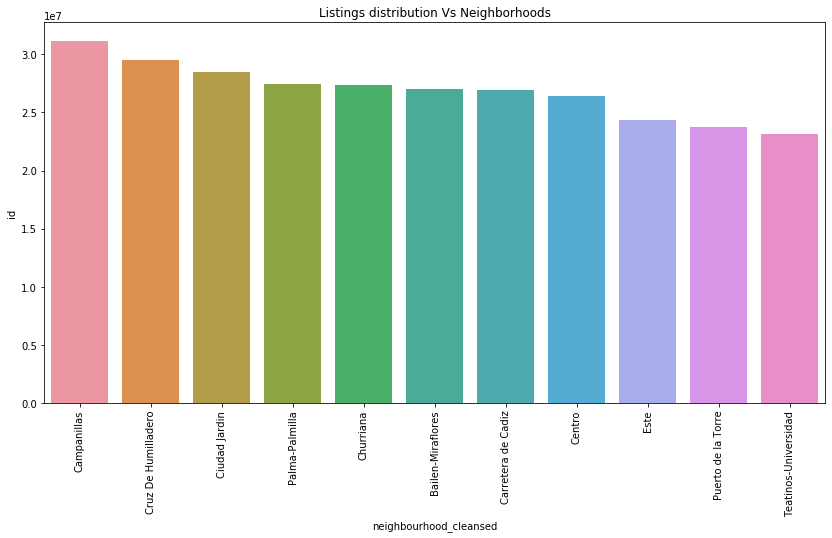

In [63]:
# Plot the average price per neighbourhoods
plt.figure(figsize=(14,7))
plt.xticks(rotation=90)
plt.xlabel('Neighborhoods')
plt.ylabel('Average number of listings')
plt.title('Listings distribution Vs Neighborhoods')
sns.barplot(neighbourhoods_popularity.index,neighbourhoods_popularity);

- Based on the above graph,
    - Campanillas, Cruz De Humilladero and Ciudad Jardin are the most crowded neighbourhoods.
    - Este, Puerto de la Torre and Teatinos-Universidad are the least crowded neighbourhoods.
    
So we can apply some rules to get the best neighbourhoods to accommodate in:

In [64]:
# Get expensive and crowded neighbourhoods
print("Expensive and crowded neighbourhood :",list(set(expensive_neighbourhoods) & set(pop_neighbourhood)))
# Get expensive and less crowded neighbourhoods
print("Expensive and less crowded neighbourhood :",list(set(expensive_neighbourhoods) & set(unpop_neighbourhood_val)))
# Get cheap and crowded neighbourhoods
print("Cheap and crowded neighbourhood :",list(set(cheap_neighbourhoods) & set(pop_neighbourhood)))
# Get cheap and less crowded neighbourhoods
print("Cheap and less crowded neighbourhood :",list(set(cheap_neighbourhoods) & set(unpop_neighbourhood)))

Expensive and crowded neighbourhood : []
Expensive and less crowded neighbourhood : []
Cheap and crowded neighbourhood : ['Ciudad Jardin', 'Cruz De Humilladero']
Cheap and less crowded neighbourhood : []


- In Conclusion,
    - The expensive neighbourhoods has a medium crowded (not extreme crowded or of the most less neighbourhoods)
    - Ciudad Jardin and Cruz De Humilladero are the cheapest but they are crowded so you have to sacrifice by adapting with crowded if you want to save some money.

## Part 3:
<h2>Which features are more involved in predicting price ?</h2>

### 1.Gather

In [45]:
# Load in listings data.
listings_df = pd.read_csv('data/listings.zip',compression='zip')

In [46]:
listings_df=listings_df[['host_response_rate', 'host_is_superhost', 'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed',
                          'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'square_feet', 'price', 'weekly_price',
                          'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'calendar_updated',
                          'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
                          'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable',
                          'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'reviews_per_month']]

### 2.Assess

In [47]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6395 entries, 0 to 6394
Data columns (total 42 columns):
host_response_rate                  5829 non-null object
host_is_superhost                   6395 non-null object
host_total_listings_count           6395 non-null int64
host_has_profile_pic                6395 non-null object
host_identity_verified              6395 non-null object
neighbourhood_cleansed              6395 non-null object
is_location_exact                   6395 non-null object
property_type                       6395 non-null object
room_type                           6395 non-null object
accommodates                        6395 non-null int64
bathrooms                           6394 non-null float64
bedrooms                            6389 non-null float64
beds                                6389 non-null float64
bed_type                            6395 non-null object
square_feet                         41 non-null float64
price                               63

In [48]:
#get some stats about data
listings_df.describe().T

,count,mean,std,min,25%,50%,75%,max
host_total_listings_count,6395.0,27.394527,66.109834,0.00,1.0,4.00,24.00,701.00
accommodates,6395.0,4.272088,2.318702,1.00,3.0,4.00,5.00,28.00
bathrooms,6394.0,1.298405,0.634424,0.00,1.0,1.00,1.50,14.00
bedrooms,6389.0,1.665049,1.175251,0.00,1.0,1.00,2.00,15.00
beds,6389.0,2.629206,1.988563,0.00,1.0,2.00,3.00,29.00
square_feet,41.0,369.000000,484.854772,0.00,0.0,0.00,657.00,1507.00
guests_included,6395.0,2.186552,1.743231,1.00,1.0,2.00,2.00,18.00
minimum_nights,6395.0,3.892729,26.321835,1.00,1.0,2.00,3.00,1124.00
maximum_nights,6395.0,797.095856,486.869724,1.00,90.0,1125.00,1125.00,1127.00
availability_30,6395.0,13.704769,10.248359,0.00,4.0,13.00,23.00,30.00


### 3.Clean & Analyzing

### I.Missing Values and Checking datatypes

In [49]:
#check the percent. null values in every col
listings_df.isna().mean().sort_values(ascending=False)

square_feet                         0.993589
monthly_price                       0.971697
weekly_price                        0.966380
security_deposit                    0.179984
review_scores_value                 0.179515
review_scores_location              0.179515
review_scores_communication         0.179515
review_scores_checkin               0.179515
review_scores_cleanliness           0.179515
review_scores_accuracy              0.179515
review_scores_rating                0.179515
reviews_per_month                   0.173417
cleaning_fee                        0.137920
host_response_rate                  0.088507
bedrooms                            0.000938
beds                                0.000938
bathrooms                           0.000156
availability_90                     0.000000
availability_60                     0.000000
host_is_superhost                   0.000000
host_total_listings_count           0.000000
host_has_profile_pic                0.000000
host_ident

- as described above these features has +90% of null values in thier columns, so I decide to drop them:   
    - square_feet   
    - monthly_price   
    - weekly_price   

In [50]:
listings_df.drop(columns=['square_feet','monthly_price','weekly_price'],inplace=True)

- Now I have to decide what to do with other columns that have null values:
    - Categorical features:
        I'll fill them with the most frequent value in the column.
    - quantitative features:
        I'll fill them with mean value of the column.

In [51]:
# Change the type of price features to float before filling nan
def process_price_column(val):
    if type(val)==str:
        val=val[1:].replace(',','')
    return val
price_cols=['price','security_deposit','cleaning_fee','extra_people']
#remove '$' and ',' from price and cast it to float
for col in price_cols:
    listings_df[col]=listings_df[col].apply(process_price_column).astype(float)
pd.DataFrame(listings_df[price_cols].sample(5))

,price,security_deposit,cleaning_fee,extra_people
3305,35.0,0.0,20.0,15.0
875,69.0,NaN,20.0,20.0
3609,70.0,0.0,40.0,20.0
128,19.0,NaN,NaN,10.0
725,60.0,0.0,25.0,10.0


In [52]:
#Impute numeric values with mean
quant_features=listings_df.select_dtypes(include=['float32','float64', 'int64']).columns
for col in list(quant_features):
    if listings_df[col].isna().mean()>0:
        listings_df[col].fillna(listings_df[col].mean(),inplace=True)

In [53]:
# Impute categorical variables with the most frequent using mode func
cat_features=listings_df.select_dtypes(include=['object']).columns
for col in list(cat_features):
    if listings_df[col].isna().mean()>0:
        listings_df[col].fillna(listings_df.mode()[col][0],inplace=True)

In [54]:
listings_df.isna().mean()

host_response_rate                  0.0
host_is_superhost                   0.0
host_total_listings_count           0.0
host_has_profile_pic                0.0
host_identity_verified              0.0
neighbourhood_cleansed              0.0
is_location_exact                   0.0
property_type                       0.0
room_type                           0.0
accommodates                        0.0
bathrooms                           0.0
bedrooms                            0.0
beds                                0.0
bed_type                            0.0
price                               0.0
security_deposit                    0.0
cleaning_fee                        0.0
guests_included                     0.0
extra_people                        0.0
minimum_nights                      0.0
maximum_nights                      0.0
calendar_updated                    0.0
availability_30                     0.0
availability_60                     0.0
availability_90                     0.0


<b>All missing values has been filled based on feature type

- Exploring Correlation between Features

In [55]:
listings_df.corr()

,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,...,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
host_total_listings_count,1.000000,0.089585,0.073124,0.049179,0.071907,0.024922,0.045776,0.107401,0.101444,0.000182,...,0.237239,-0.159985,-0.091816,-0.079818,-0.053826,-0.109194,-0.087959,-0.009178,-0.086368,-0.132177
accommodates,0.089585,1.000000,0.544192,0.778075,0.828827,0.090302,0.182548,0.303016,0.625829,0.201236,...,0.055979,-0.098021,-0.002020,-0.030140,-0.035578,-0.015123,0.005291,-0.011642,-0.035321,-0.138547
bathrooms,0.073124,0.544192,1.000000,0.620358,0.581578,0.152739,0.166284,0.305279,0.339704,0.104152,...,-0.013428,-0.057924,0.049188,0.019934,0.019153,0.024163,0.038123,0.018904,0.028843,-0.087644
bedrooms,0.049179,0.778075,0.620358,1.000000,0.783953,0.110682,0.196275,0.336613,0.490673,0.135500,...,-0.033700,-0.091812,0.046982,0.017312,0.006857,0.029327,0.032573,-0.043652,0.013079,-0.144558
beds,0.071907,0.828827,0.581578,0.783953,1.000000,0.081857,0.178697,0.306821,0.519332,0.154099,...,0.019278,-0.076546,0.025406,-0.003663,-0.005300,0.022075,0.030681,-0.017522,-0.010112,-0.121060
price,0.024922,0.090302,0.152739,0.110682,0.081857,1.000000,0.025035,0.025980,0.051592,-0.011605,...,0.054755,-0.052990,0.005572,-0.013714,0.001307,-0.008665,-0.001318,0.009593,-0.003020,-0.039362
security_deposit,0.045776,0.182548,0.166284,0.196275,0.178697,0.025035,1.000000,0.290873,0.124860,0.069746,...,0.013575,-0.047397,0.039350,0.022655,0.033653,0.013435,0.024805,0.001933,0.012557,-0.094520
cleaning_fee,0.107401,0.303016,0.305279,0.336613,0.306821,0.025980,0.290873,1.000000,0.203312,0.053035,...,0.040992,-0.081696,0.062193,0.047425,0.053088,0.039048,0.030469,0.021595,0.038075,-0.118446
guests_included,0.101444,0.625829,0.339704,0.490673,0.519332,0.051592,0.124860,0.203312,1.000000,0.309521,...,0.073248,-0.065185,-0.028008,-0.052735,-0.026484,-0.035838,-0.019070,-0.027335,-0.060165,-0.112084
extra_people,0.000182,0.201236,0.104152,0.135500,0.154099,-0.011605,0.069746,0.053035,0.309521,1.000000,...,0.038206,0.014604,0.041629,0.010170,0.050868,-0.000695,0.032064,0.055589,0.035467,-0.056728


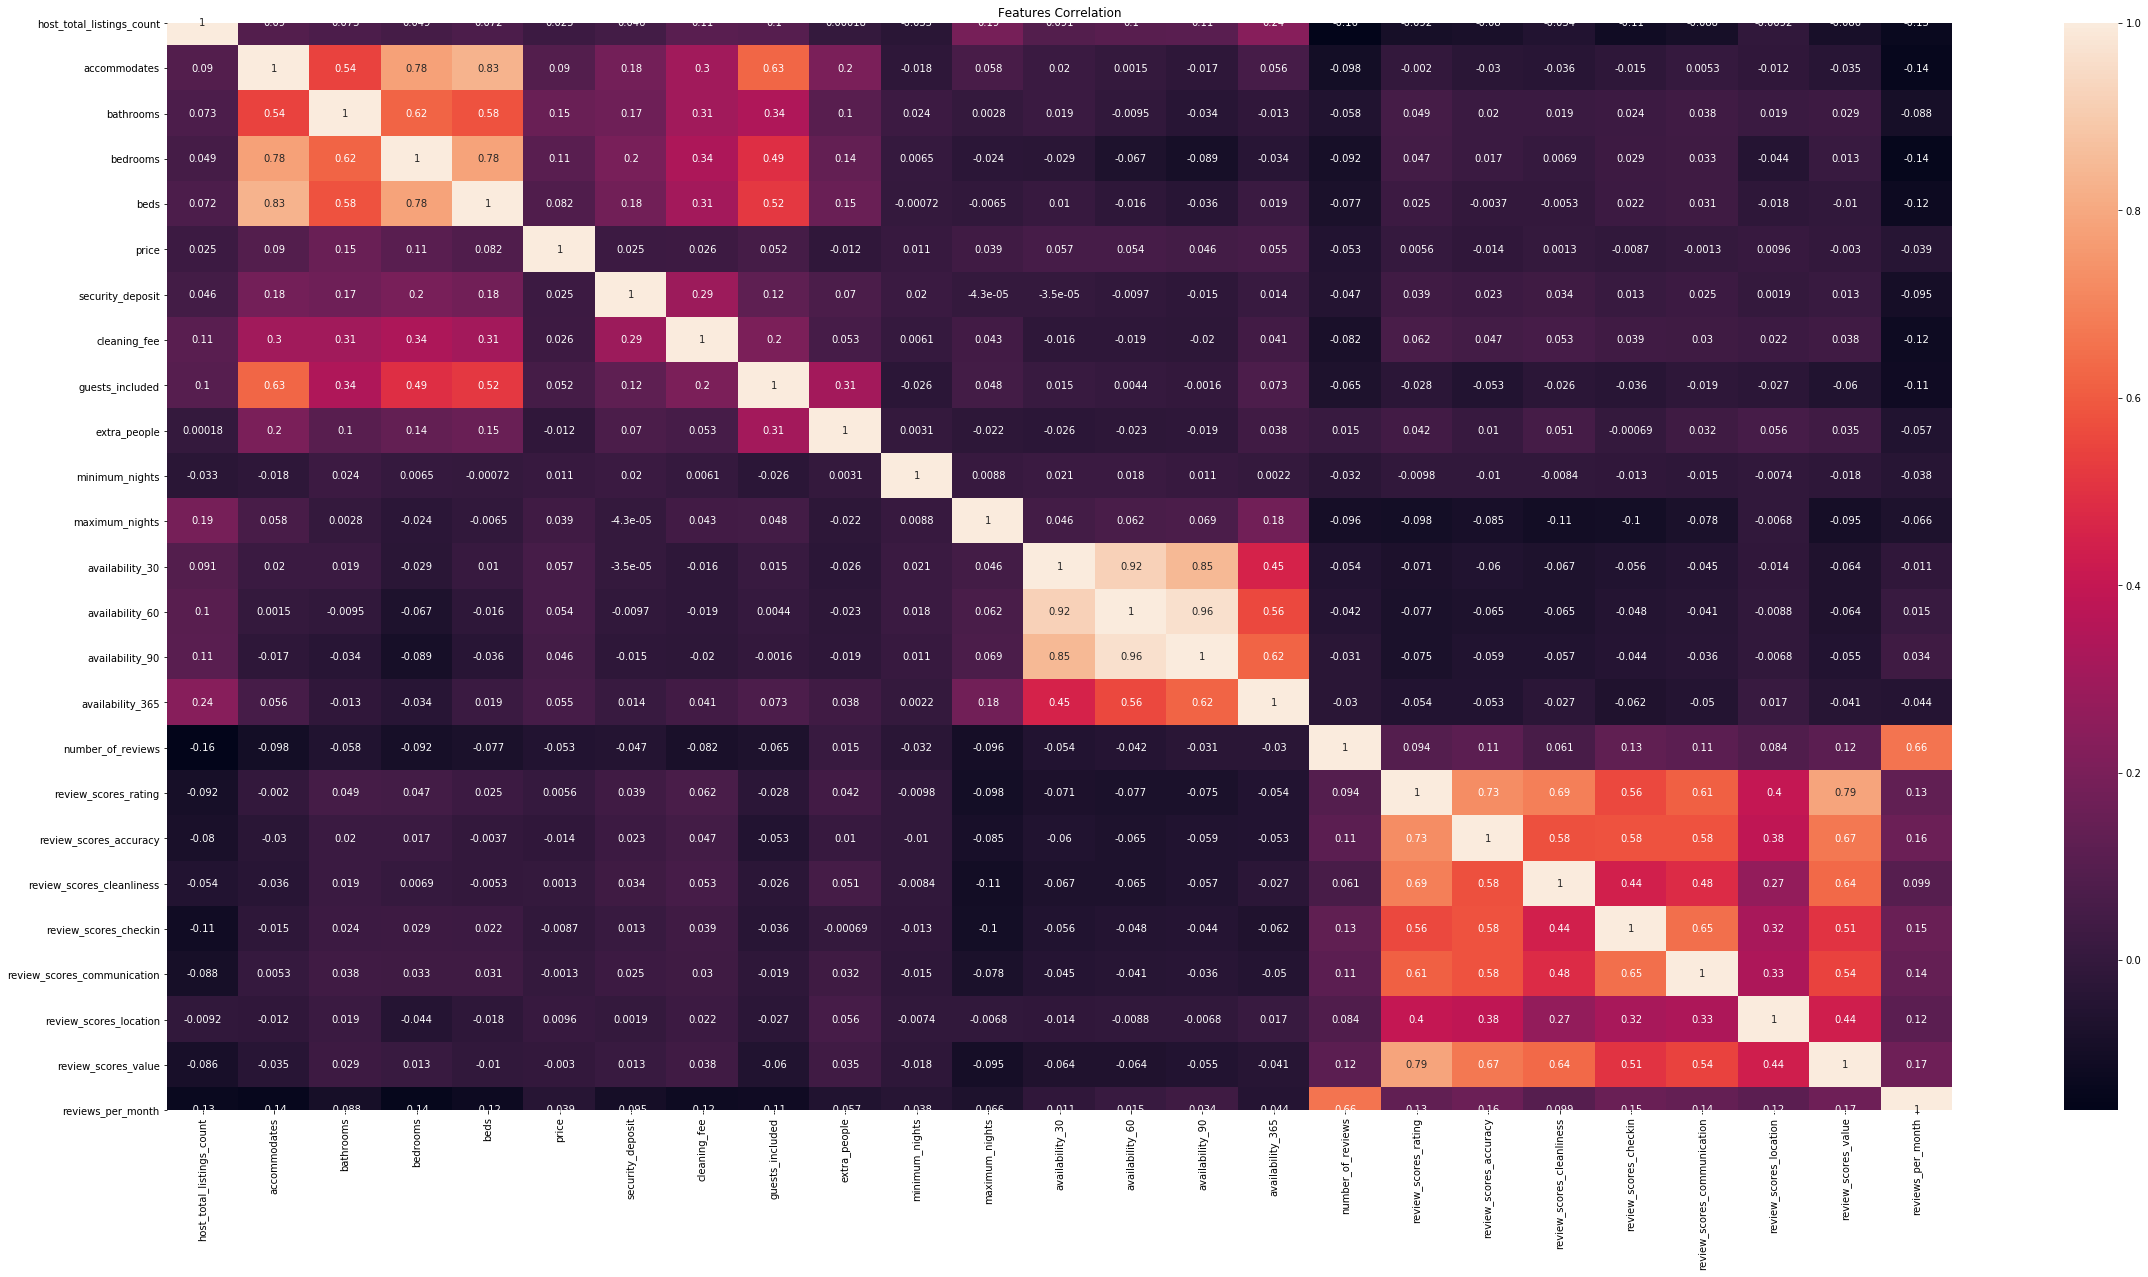

In [56]:
plt.figure(figsize=(40,20))
plt.title("Features Correlation")
sns.heatmap(listings_df.corr(),annot=True);

- based don above graph I found correlations between some group of features like:   
    - availability features (availability_30,availability_60,availability_90,availability_365)   
    - review features(review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location,review_scores_value)
- So I decided to keep one feature of each group

In [57]:
listings_df.drop(columns=['availability_30','availability_60','availability_90',
                          'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                          'review_scores_communication', 'review_scores_location','review_scores_value'],inplace=True)

In [58]:
listings_df.columns

Index(['host_response_rate', 'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'is_location_exact', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'calendar_updated', 'availability_365', 'number_of_reviews',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'reviews_per_month'],
      dtype='object')

- Encode Categorical Features

In [59]:
# Dummy the categorical variables
for var in  cat_features:
    listings_df = pd.concat([listings_df.drop(var, axis=1), 
                                    pd.get_dummies(listings_df[var], prefix=var, prefix_sep='_', drop_first=False)],
                                   axis=1)
listings_df.head()

,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,...,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_phone_verification_f,require_guest_phone_verification_t
0,1,3,1.0,2.0,2.0,49.0,150.000000,0.000000,3,15.0,...,1,0,0,1,0,0,0,1,0,1
1,2,1,2.0,2.0,2.0,30.0,0.000000,0.000000,1,0.0,...,0,0,0,1,0,0,1,0,1,0
2,1,3,1.0,2.0,3.0,37.0,200.000000,20.000000,1,10.0,...,1,0,1,0,0,0,0,1,0,1
3,1,5,2.5,3.0,5.0,180.0,500.000000,40.000000,4,20.0,...,0,0,0,1,0,0,1,0,0,1
4,1,6,1.0,3.0,6.0,60.0,116.043097,27.263922,4,10.0,...,0,1,0,0,0,0,0,1,1,0


### Model & Visualize

- In this step I'll follow these steps:
    - Splitting data into features and traget   
    - Scale the features   
    - Splitting data into training and testing   
    - Model Training  
    - Model Optimization
    - Model Evaluation   
    - Getting the most important features


- Splitting data into features and traget

In [60]:
# Create X variable with all features without price
X= listings_df.drop(columns=['price'])

# Create Y variable with only price feature
y= listings_df['price']

- Scale the features

In [61]:
# Apply feature scaling to the listings data.
st_scaler= StandardScaler()
X= pd.DataFrame(data=st_scaler.fit_transform(X), index=X.index, columns=X.columns)

- Splitting data into training and testing

In [77]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [78]:
# Create RandomForest Regression model
forest_reg = RandomForestRegressor(n_estimators=10)

# Fit the model
forest_reg.fit(X_train, y_train)

# Get MAE value
y_predict = forest_reg.predict(X_test)
model_mae = mean_absolute_error(y_test, y_predict)
print('MAE: {:.4}'.format(model_mae))

MAE: 39.0


- Model optimization

In [64]:
# Set GridSearchCV parameters to find the best parameter tuning for the model
parameters = {
    'bootstrap': [True, False],
    'n_estimators': [10, 50, 100],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create GridSearchCV
forest_reg_cv= GridSearchCV(forest_reg, parameters,cv=5)

# Fit model
forest_reg_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

- Model Evaluation

In [65]:
# Get MAE value
y_predict = forest_reg_cv.predict(X_test)
model_mae = mean_absolute_error(y_test, y_predict)
print('MAE: {:.4}'.format(model_mae))

MAE: 36.26


- Getting the most important features

In [74]:
# Get feature_importances of model
feature_importances = forest_reg_cv.best_estimator_.feature_importances_

# Sort feature importance and get the first 5 features
feature_importances_df= pd.DataFrame(data=feature_importances, index=X.columns) 
feature_importances_sorted=feature_importances_df[0].sort_values(ascending=False)
feature_importances_sorted_10=feature_importances_sorted[:10]
pd.DataFrame(feature_importances_sorted_10)

,0
property_type_Boutique hotel,0.160943
host_total_listings_count,0.082144
availability_365,0.064323
host_identity_verified_t,0.062216
calendar_updated_a week ago,0.061269
number_of_reviews,0.049451
reviews_per_month,0.048238
host_identity_verified_f,0.041692
accommodates,0.038954
extra_people,0.031835


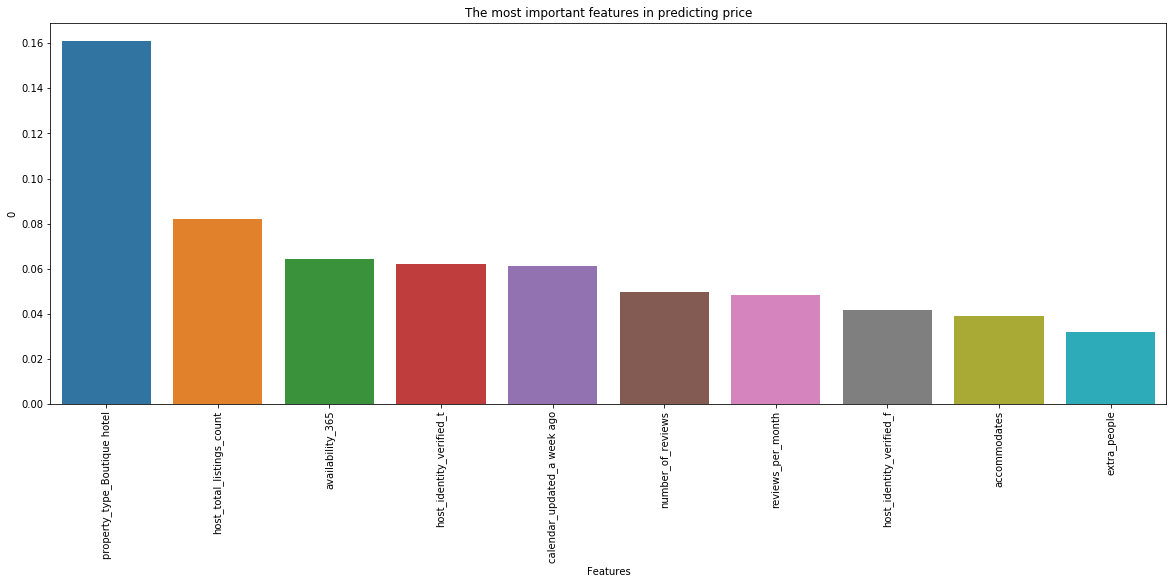

In [67]:
# Plot the important features vs importance score
plt.figure(figsize=(20,7))
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature_importances')
plt.title('The most important features in predicting price')
sns.barplot(feature_importances_sorted_10.index,feature_importances_sorted_10);

Based on the above analysis, The top 10 features to predict price are:
1. property_type_Boutique hotel: property type.   
2. host_total_listings_count: number of how many this host listed.    
3. availability_365: Number of available days listed.  
4. host_identity_verified: host verification.   
5. calendar_updated_a week ago: The last week, the listing was reserved.
6. number_of_reviews: number of reviews all the time.      
7. reviews_per_month: The number of monthly reviews which helps to know if host is active.   
8. accommodates: The number of people to be accommodated. 
9. extra_people: Availability to have extra people. 
10. cleaning_fee: The cost of cleaning service (this feature shifted because host_identity_verified takes two places so I kept with one of them).   